# Alzheimer's Detection Model with ViT Head

## Overview
This TensorFlow/Keras model detects Alzheimer’s disease using MRI images. It uses transfer learning with a pre-trained MobileNetV2 as the base network and augments it with a custom Vision Transformer (ViT) head. Training is performed in two phases: initial training with a frozen base model and a fine-tuning phase where certain layers are unfrozen.

## Data Pipeline
- **Dataset Download:**  
  The dataset is downloaded using `kagglehub` and is expected to contain PNG images sorted into folders by diagnosis.
- **Label Mapping:**  
  Two mappings are defined:
  - Numeric-to-diagnosis (e.g., 0: 'CN', 4: 'AD').
  - Folder name to numeric label.
- **Image Processing:**  
  Images are read from disk, decoded, resized to 160×160, normalized, and their labels are one-hot encoded.
- **Data Pipeline:**  
  Constructed using the `tf.data` API, with operations including shuffling, mapping, caching, batching, and prefetching for efficient training.

## Model Architecture
- **Base Network (MobileNetV2):**  
  - Pre-trained on ImageNet (without the top classifier).
  - Input: 160×160×3 images.
  - **Layer Freezing:** Approximately 90% of the layers are frozen during the initial phase.
  
- **Vision Transformer (ViT) Head:**  
  - **Projection Layer:** Projects patch features into a defined embedding space.
  - **Class Token:** A learnable token is prepended to the patch sequence.
  - **Positional Embeddings:** Learnable positional information is added.
  - **Transformer Blocks:** Multiple blocks consisting of layer normalization, multi-head self-attention, MLP layers (with gelu activation and dropout), and residual connections.
  - **Output:** The final class token is extracted as the representative feature.

- **Classification Head:**
  - A Dropout layer (50%) is applied.
  - A Dense layer with softmax activation outputs class probabilities (for 5 classes).

## Training Strategy
- **Phase 1: Training with Frozen Base**
  - **Objective:** Train only the top layers (ViT head and classifier) while keeping most of the MobileNetV2 weights fixed.
  - **Optimizer:** Adam with a learning rate of 1e-4.
  - **Loss:** Categorical crossentropy.
  - **Epochs:** 5 (initial phase; adjustable).
  
- **Phase 2: Fine-Tuning**
  - **Objective:** Unfreeze the last 10% of the MobileNetV2 layers to fine-tune the model.
  - **Optimizer:** Adam with a reduced learning rate of 1e-5.
  - **Epochs:** Additional 5 epochs (adjustable).

## Evaluation and Visualization
- **Callbacks:**  
  EarlyStopping and ModelCheckpoint are used to prevent overfitting and store the best model based on validation loss.
- **Training Visualization:**  
  A plotting function displays the accuracy and loss curves for both phases.
- **Final Evaluation:**  
  The model is evaluated on the validation set, and the final validation accuracy is reported.

## Inspiration 
We analyzed 2 papers published in 2025 
- HybridViT: An Approach for Alzheimer’s Disease Classification 
with ADNI Neuroimaging Data

- Hybrid-RViT: Hybridizing ResNet-50 and Vision
 Transformer for Enhanced Alzheimer’s disease detection

and set them as our base and inspiration for this model,
Both HybridViT and Hybrid-RViT showcase the power of hybrid CNN–ViT architectures for classifying Alzheimer’s disease stages using MRI, and they can be adapted to the user’s context of detecting AD progression (particularly within the ADNI dataset). In terms of ADNI utilization, HybridViT already directly uses ADNI data, demonstrating that a hybrid model can distinguish Normal, EMCI, LMCI, MCI, and AD with high accuracy​. Hybrid-RViT, while developed on OASIS, was conceptually aligned to ADNI’s categories and could be retrained on ADNI’s much larger sample to potentially achieve even better performance on detecting subtle progression. 

  ## Short-Comings and Further Improvements
  -Our initial Model started with ResNet50 as our base model but we switched to MobileNetV2 for faster training times, 
  we trained for only 5 epochs this time due to training constraints and no image preprocessing other then resizing was applied
  - ## Improvements: 
       - Move to ResNet50 as the base model
       - Add additional image pre-processing steps
       - Train for higher Epochs
       - Evaluate on OASIS and other datasets and imrpove on better validation accuracy



In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.mixed_precision import set_global_policy
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
import kagglehub

2025-04-15 15:38:32.397556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744731512.587190      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744731512.647498      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset downloaded to: /kaggle/input/adni-images-for-alzheimer-detection


Class distribution:
Class CN: 4077 images
Class MCI: 4073 images
Class EMCI: 3958 images
Class LMCI: 4074 images
Class AD: 4075 images
Training set: 16205 images
Validation set: 4052 images


I0000 00:00:1744731525.728380      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training with frozen base model
Epoch 1/5


I0000 00:00:1744731547.785537      92 service.cc:148] XLA service 0x7d4f50002210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744731547.786348      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744731549.966705      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/254 ━━━━━━━━━━━━━━━━━━━━ 2:27:44 35s/step - accuracy: 0.2500 - loss: 2.7832

I0000 00:00:1744731563.433307      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


254/254 ━━━━━━━━━━━━━━━━━━━━ 105s 275ms/step - accuracy: 0.3910 - loss: 1.7492 - val_accuracy: 0.3889 - val_loss: 2.2214
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7368 - loss: 0.5551 - val_accuracy: 0.5000 - val_loss: 1.9131
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7822 - loss: 0.3910 - val_accuracy: 0.4854 - val_loss: 2.8595
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7929 - loss: 0.3445 - val_accuracy: 0.6061 - val_loss: 1.7216
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8025 - loss: 0.3276 - val_accuracy: 0.6355 - val_loss: 1.8899

Phase 2: Fine-tuning
Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - accuracy: 0.7985 - loss: 0.3150 - val_accuracy: 0.6535 - val_loss: 1.0344
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8006 - loss: 0.2986 - val_accuracy: 0.6987 - val_loss: 0.6270
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8056 - loss: 0.2926 -

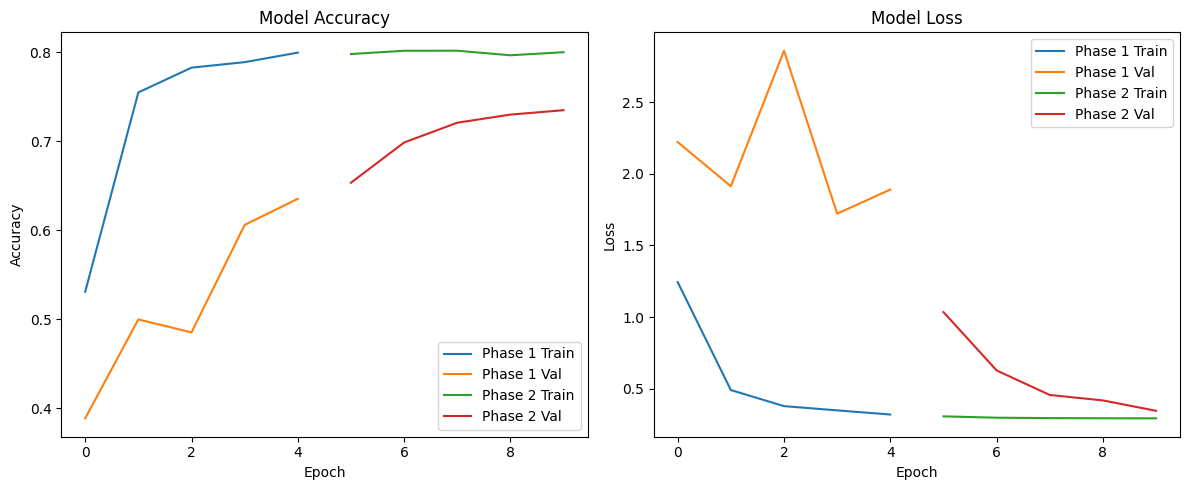

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7266 - loss: 0.3581

Final Validation Accuracy: 0.7349


In [1]:
set_global_policy('mixed_float16')#added mix-precision here its faster
print("Downloading dataset...")
data_dir = kagglehub.dataset_download("proutkarshtiwari/adni-images-for-alzheimer-detection")
print(f"Dataset downloaded to: {data_dir}")
#label mapping
diagnosis_mapping = {
    0: 'CN',    
    1: 'MCI',   
    2: 'EMCI', 
    3: 'LMCI',  
    4: 'AD'     
}
dir_to_code = {
    'CN': 0,
    'MCI': 1,
    'EMCI': 2,
    'LMCI': 3,
    'AD': 4
}
def get_image_paths_and_labels():
    image_paths=[]
    labels=[]
    
    images_dir=os.path.join(data_dir, 'ADNI_IMAGES', 'png_images')
    
    for class_name, class_code in dir_to_code.items():
        class_dir=os.path.join(images_dir, class_name)
        if os.path.exists(class_dir):
            png_files=[f for f in os.listdir(class_dir) if f.lower().endswith('.png')]
            for file in png_files:
                image_paths.append(os.path.join(class_dir, file))
                labels.append(class_code)
    
    return np.array(image_paths), np.array(labels)


print("\nCollecting image paths and labels...")
image_paths, labels = get_image_paths_and_labels()
unique, counts = np.unique(labels, return_counts=True)
print("\nClass distribution:")
for label, count in zip(unique, counts):
    print(f"Class {diagnosis_mapping[label]}: {count} images")


#train & validation
train_paths,val_paths,train_labels,val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

IMAGE_SIZE = (160, 160)#before 224
BATCH_SIZE = 64 
NUM_CLASSES = len(diagnosis_mapping)

def decode_image(file_path, label):
    img =tf.io.read_file(file_path)
    img =tf.image.decode_png(img, channels=3)
    img =tf.image.resize(img, IMAGE_SIZE)
    img =tf.cast(img, tf.float32) / 255.0
    label =tf.one_hot(label, NUM_CLASSES)
    return img, label

#dataset
#train
train_ds =tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds =train_ds.shuffle(buffer_size=len(train_paths))  
train_ds =train_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)#add auto tune for better fetch
train_ds =train_ds.cache()  # cache is fast
train_ds =train_ds.batch(BATCH_SIZE)
train_ds =train_ds.prefetch(tf.data.AUTOTUNE)
#val
val_ds =tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds =val_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds =val_ds.cache() 
val_ds =val_ds.batch(BATCH_SIZE)
val_ds =val_ds.prefetch(tf.data.AUTOTUNE)

#ViT Head
class ViTHead(layers.Layer):
    def __init__(self, embed_dim=256, num_heads=4, mlp_dim=512, num_transformer_layers=2, dropout_rate=0.1, **kwargs):
        super(ViTHead, self).__init__(**kwargs)
        self.embed_dim =embed_dim
        self.num_heads= num_heads
        self.mlp_dim =mlp_dim
        self.num_transformer_layers =num_transformer_layers
        self.dropout_rate =dropout_rate

    def build(self, input_shape):
        self.num_patches =input_shape[1] * input_shape[2]  # 5x5 
        self.feature_dim =input_shape[3]
        self.projection =layers.Dense(self.embed_dim)#proj
        self.cls_token =self.add_weight(#cls token gen
            shape=(1, 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )#pos-embedding
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches + 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="pos_embed"
        )
        self.transformer_blocks = []
        for _ in range(self.num_transformer_layers):
            self.transformer_blocks.append([
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(#mla
                    num_heads=self.num_heads,
                    key_dim=self.embed_dim // self.num_heads,
                    dropout=self.dropout_rate
                ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(self.mlp_dim, activation="gelu"),
                layers.Dropout(self.dropout_rate),
                layers.Dense(self.embed_dim)
            ])
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        batch_size =tf.shape(inputs)[0]
        x= tf.reshape(inputs, [batch_size, self.num_patches, self.feature_dim])
        x= self.projection(x)
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        x= tf.concat([cls_tokens, x], axis=1)
        x= x + self.pos_embed
        
        for norm1, attn, norm2, dense1, drop1, dense2 in self.transformer_blocks:
            x_norm =norm1(x)
            attention_output =attn(x_norm, x_norm, x_norm, training=training)
            x=x+attention_output
            x_norm =norm2(x)
            x_mlp =dense1(x_norm)
            x_mlp =drop1(x_mlp, training=training)
            x_mlp= dense2(x_mlp)
            x = x + x_mlp
        
        x = self.layer_norm(x)
        return x[:, 0]  

# Base-model
base_model=MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMAGE_SIZE, 3)
)

#90%freeze next improvement:~80%
layer_n =len(base_model.layers)
freeze =int(layer_n * 0.9)
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= freeze)

#complete model
inputs =layers.Input(shape=(*IMAGE_SIZE, 3))
x =base_model(inputs, training=False)
vit_out =ViTHead(embed_dim=256,num_heads=4,mlp_dim=512,num_transformer_layers=2,dropout_rate=0.1)(x)
x =layers.Dropout(0.5)(vit_out)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(1e-4),loss="categorical_crossentropy",metrics=["accuracy"],jit_compile=True)
early_stop =callbacks.EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)
checkpoint =callbacks.ModelCheckpoint("alzheimer_mobilenet_phase1.keras",monitor="val_loss",save_best_only=True)

#Phase 1
print("\nPhase 1: Training with frozen base model")#increase epoch next time
history_phase1 = model.fit( train_ds,validation_data=val_ds,epochs=5,callbacks=[early_stop, checkpoint])
# Phase 2
for layer in base_model.layers[freeze:]:
    layer.trainable = True
model.compile(optimizer=optimizers.Adam(1e-5),loss="categorical_crossentropy",metrics=["accuracy"],jit_compile=True)


print("\nPhase 2: Fine-tuning")
checkpoint_ft = callbacks.ModelCheckpoint("alzheimer_mobilenet_phase2.keras",monitor="val_loss",save_best_only=True)
history_phase2 = model.fit( train_ds, validation_data=val_ds, epochs=5,callbacks=[early_stop, checkpoint_ft])
model.save("final_alzheimer_mobilenet.keras")

# Plot 
def plot_history(history1, history2):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Phase 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Phase 1 Val')
    offset = len(history1.history['accuracy'])
    x2 = [offset + i for i in range(len(history2.history['accuracy']))]
    plt.plot(x2, history2.history['accuracy'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_accuracy'], label='Phase 2 Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend() 
    #loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Phase 1 Train')
    plt.plot(history1.history['val_loss'], label='Phase 1 Val')
    plt.plot(x2, history2.history['loss'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_loss'], label='Phase 2 Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_history(history_phase1, history_phase2)
#Eval
test_loss, test_acc = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {test_acc}")